In [117]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [118]:
train_dataset = datasets.MNIST('data/',download=True,train=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                               ]))
test_dataset = datasets.MNIST('data/',download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                              ]))

In [4]:
train_dataset

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

In [119]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)

        return e6

In [120]:
model = Net()

In [121]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

In [122]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test
num_folds = 5
fold_num = 0
train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [123]:
model = Net()

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, 4, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, 4, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()
for epoch in range(200000):
    
    pred = model(inp)
#     print(pred.shape)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %1000 == 0:
        
        
        test_pr = model(test_inp)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])

0 Training Error: 18.764814376831055 Test Error: 11.271512031555176
1000 Training Error: 18.545501708984375 Test Error: 11.040716171264648
2000 Training Error: 18.528995513916016 Test Error: 11.026710510253906
3000 Training Error: 18.531017303466797 Test Error: 11.026530265808105
4000 Training Error: 18.532575607299805 Test Error: 11.025772094726562
5000 Training Error: 18.530517578125 Test Error: 11.027676582336426
6000 Training Error: 18.53147315979004 Test Error: 11.026638984680176
7000 Training Error: 18.531530380249023 Test Error: 11.026496887207031
8000 Training Error: 18.528091430664062 Test Error: 11.026249885559082
9000 Training Error: 18.528623580932617 Test Error: 11.028401374816895
10000 Training Error: 18.52834129333496 Test Error: 11.028719902038574
11000 Training Error: 18.529083251953125 Test Error: 11.032057762145996
12000 Training Error: 18.534902572631836 Test Error: 11.02681827545166
13000 Training Error: 18.529254913330078 Test Error: 11.030102729797363
14000 Train

115000 Training Error: 18.506633758544922 Test Error: 11.090599060058594
116000 Training Error: 18.507076263427734 Test Error: 11.090375900268555
117000 Training Error: 18.50558853149414 Test Error: 11.094084739685059
118000 Training Error: 18.504148483276367 Test Error: 11.100774765014648
119000 Training Error: 18.505327224731445 Test Error: 11.093608856201172
120000 Training Error: 18.503475189208984 Test Error: 11.0945463180542
121000 Training Error: 18.501909255981445 Test Error: 11.097972869873047
122000 Training Error: 18.50635528564453 Test Error: 11.093266487121582
123000 Training Error: 18.502288818359375 Test Error: 11.10168743133545
124000 Training Error: 18.509906768798828 Test Error: 11.099620819091797
125000 Training Error: 18.50172996520996 Test Error: 11.101394653320312
126000 Training Error: 18.50162696838379 Test Error: 11.11140251159668
127000 Training Error: 18.498750686645508 Test Error: 11.125680923461914
128000 Training Error: 18.5003719329834 Test Error: 11.1297

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [125]:
test_pr = torch.clamp(test_pr, min=0.)


14


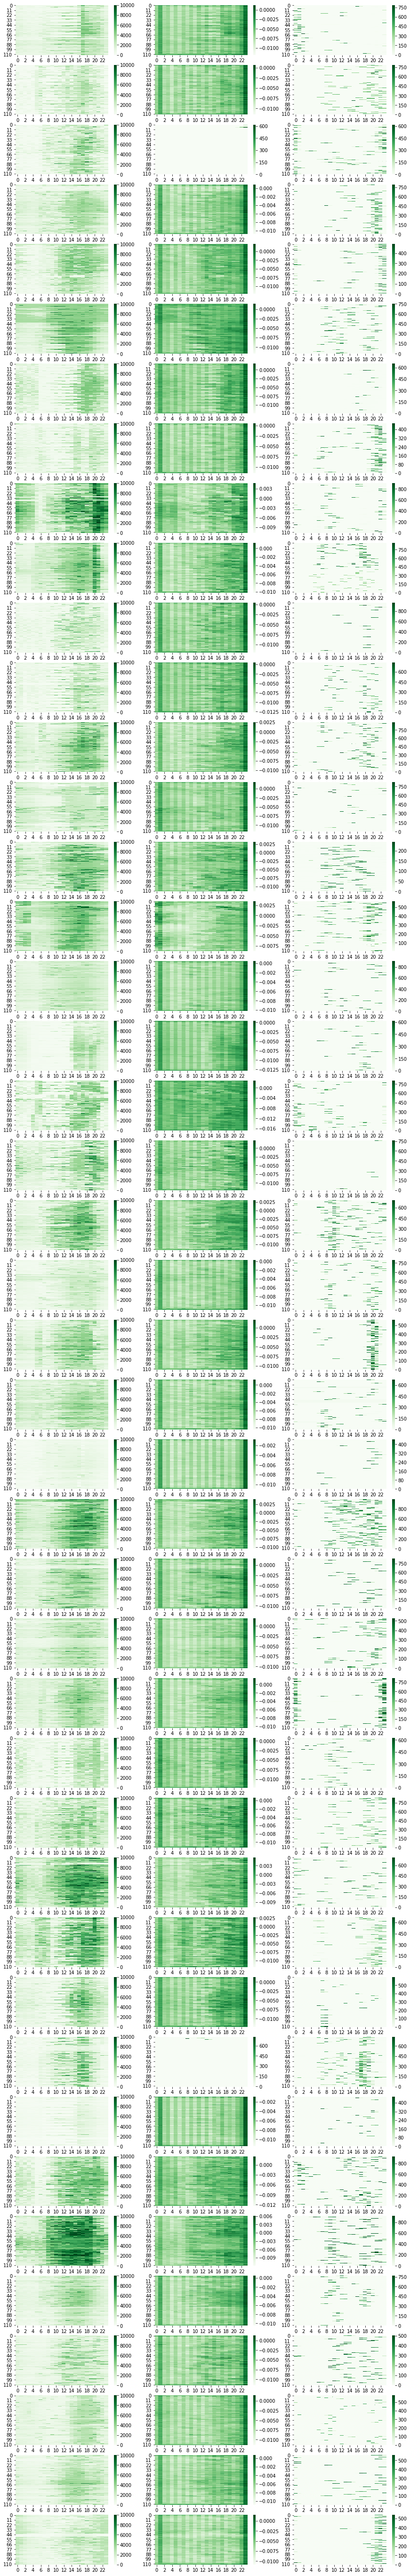

In [127]:
num_train = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_train,ncols=3, figsize=(15, 100))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




14


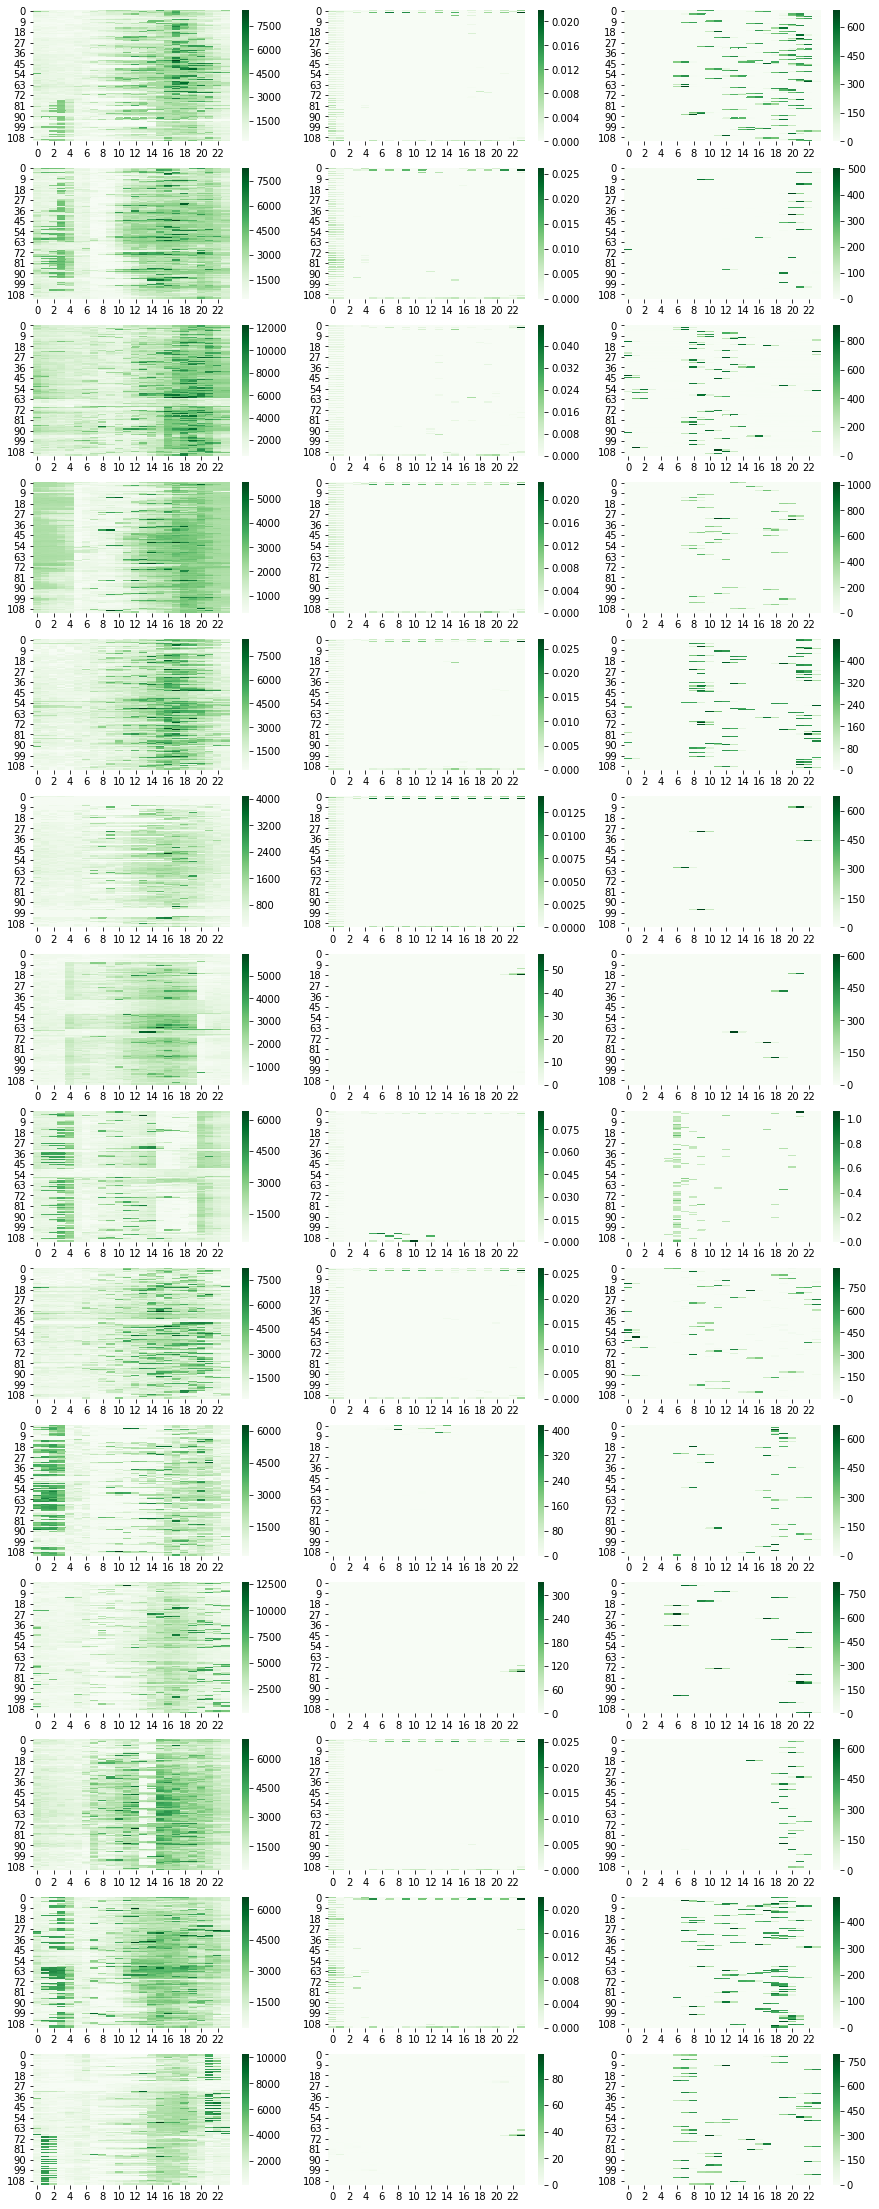

In [128]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




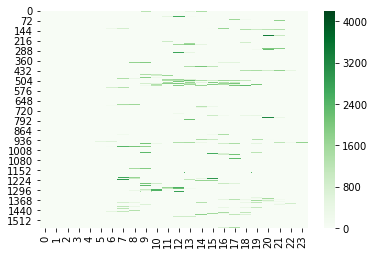

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')